# Text Readability

## Flesch Reading Ease

[textstat library](https://pypi.org/project/textstat/)

For readability, we use flesch_reading_ease, that returns the Flesch Reading Ease Score. The table is an example of values.

|Score|	Difficulty|
|---|---|
|90-100	|Very easy to read. Easily understood by an average 11-year-old student.|
|80-89	|Easy to read. Conversational English for consumers.|
|70-79	|Fairly Easy to read.|
|60-69	|Plain English. Easily understood by 13- to 15-year-old students.|
|50-59	|Fairly Difficult to read.|
|30-49	|Difficult to read, college level.|
|10-29	|Very difficult to read. Best understood by university graduates.|
|0-9    |Extremely difficult to read. Best understood by university graduates.|

In [7]:
import json
import re
from html import unescape
from textstat import flesch_reading_ease
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

color_palette = ['#5565cf', '#b14ecf', '#cf4773', '#cf913f', '#87cf38', '#30cf6b', '#29a1cf', '#2138cf']

file_path = 'data_stories_summary.json'
with open(file_path, 'r') as file:
    data = json.load(file)

In [ ]:
# Utility function to clean HTML and special characters
def clean_text(html_text):
    # Unescape HTML entities
    text = unescape(html_text)
    # Remove HTML tags
    text = re.sub(r"<[^>]+>", "", text)
    # Replace non-breaking space and other escaped characters
    text = text.replace("\xa0", " ").strip()
    return text

def normalize_flesch(score):
    # This centers 60 as ~0.5 and compresses extremes between 0 and 1
    return 1 / (1 + np.exp(-0.1 * (score - 60)))

results = []

for story_id, story in data.items():
    raw_texts = story.get("texts", [])
    cleaned_texts = [clean_text(t) for t in raw_texts]
    
    # Combine into one single string for readability analysis
    full_text = " ".join(cleaned_texts)
    
    # Calculate the Flesch reading ease, if the text is not empty
    if full_text.strip():
        fr_score = flesch_reading_ease(full_text)
        normalized_score = normalize_flesch(fr_score)
    else:
        fr_score = 0

    results.append({
        "story_id": story_id,
        "flesch_reading_ease": fr_score,
        "normalized_readability": normalized_score
    })

flesch_reading_df = pd.DataFrame(results)
flesch_reading_df.to_csv("outputs/readability_scores.csv")


    story_id  flesch_reading_ease  normalized_readability
0   D-hp3wDV                33.14                0.063805
1   y4Srva15                51.18                0.292764
2   7qpfziir                61.36                0.533948
3   Nokx0yU6                49.15                0.252561
4   gz_gxhYn                41.70                0.138238
5   U2OtB3XT                61.97                0.549091
6   v4h_GSI0                34.97                0.075648
7   1ptR3pru                71.44                0.758413
8   JQpdcw-d                47.49                0.222527
9   B9SLlUry                63.59                0.588798
10  r7i-PG2n                41.40                0.134703
11  AUmcnOzL                41.29                0.133426
12  tyK82z37                34.19                0.070371
13  IRRbkmZk                48.84                0.246754
14  Vy4_Rxzv                44.44                0.174221
15  M9EZmoBI                47.01                0.214333
16  uhDaBOl1  

## Correlation Readability X SPARQL Profiency

In [2]:
df_readability = pd.read_csv('outputs/readability_scores.csv', index_col=0)
df_sparql = pd.read_csv('outputs/sparql_proficiency_final.csv', index_col=0)
df_alternation = pd.read_csv('outputs/alternation_scores.csv', index_col=0)

df_temp = pd.merge(df_readability[['story_id', 'flesch_reading_ease', 'normalized_readability']],
                       df_sparql[['story_id', 'sparql_proficiency']],
                       on='story_id', how='inner')

df_combined = pd.merge(
    df_temp,
    df_alternation[['story_id', 'alternation_score']],
    on='story_id',
    how='inner'
)

story_no_text = ['SXefpzf4', 'EzsIH_Et', '6yGct8pP']

df_filtered = df_combined[~df_combined['story_id'].isin(story_no_text)]

print(df_filtered)


    story_id  flesch_reading_ease  normalized_readability  sparql_proficiency  \
0   D-hp3wDV                33.14                0.063805            0.295677   
1   y4Srva15                51.18                0.292764            0.250303   
2   7qpfziir                61.36                0.533948            0.252453   
3   Nokx0yU6                49.15                0.252561            0.230757   
4   gz_gxhYn                41.70                0.138238            0.226993   
5   U2OtB3XT                61.97                0.549091            0.262949   
6   v4h_GSI0                34.97                0.075648            0.265419   
7   1ptR3pru                71.44                0.758413            0.221285   
8   JQpdcw-d                47.49                0.222527            0.186595   
9   B9SLlUry                63.59                0.588798            0.267813   
10  r7i-PG2n                41.40                0.134703            0.442157   
11  AUmcnOzL                

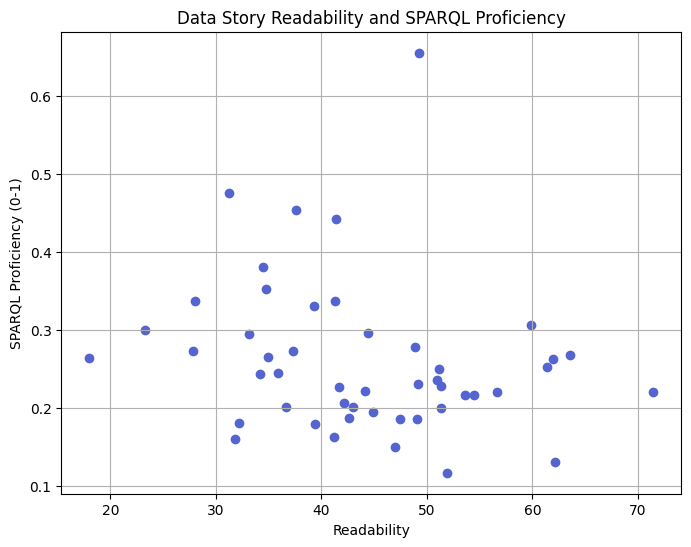

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df_filtered['flesch_reading_ease'], df_filtered['sparql_proficiency'], color=color_palette[0])
plt.xlabel("Readability")
plt.ylabel("SPARQL Proficiency (0-1)")
plt.title("Data Story Readability and SPARQL Proficiency")
plt.grid(True)
plt.show()

In [ ]:
# Pearson
pearson_corr, pearson_p = pearsonr(df_filtered['flesch_reading_ease'], df_filtered['sparql_proficiency'])

# Spearman
spearman_corr, spearman_p = spearmanr(df_filtered['flesch_reading_ease'], df_filtered['sparql_proficiency'])

print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")


Pearson correlation: -0.215 (p-value: 0.143)
Spearman correlation: -0.291 (p-value: 0.045)


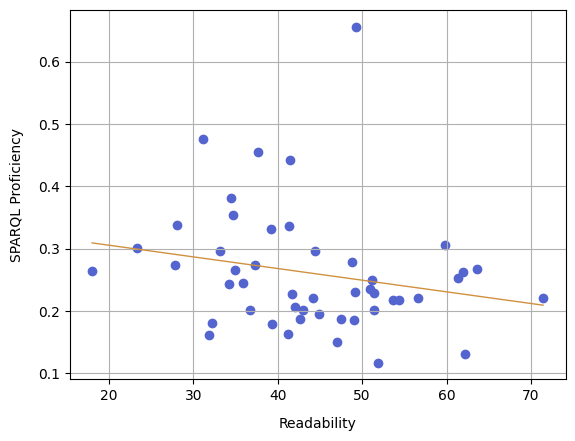

In [ ]:
x = np.array(df_filtered['flesch_reading_ease'])
y = np.array(df_filtered['sparql_proficiency'])
 
# Compute best-fit line (linear regression)
m, b = np.polyfit(x, y, 1)  # 1st-degree polynomial (y = mx + b)
 
# Create scatter plot
plt.scatter(x, y, color=color_palette[0], label="Data points")
 
# Plot best-fit line
x_sorted = np.sort(x)
plt.plot(x_sorted, m*x_sorted + b, color=color_palette[3], linewidth=1, label="Best-fit line")
 
# Labels and title
plt.xlabel("Readability", labelpad=10)
plt.ylabel("SPARQL Proficiency", labelpad=10)
plt.grid(True)
# Save as JPG with 300 dpi
# plt.savefig("outputs/img/12.jpg", dpi=300, bbox_inches="tight", format="jpg")

# Save as EPS (vector format, resolution-independent)
# plt.savefig("outputs/img/12.eps", format="eps", bbox_inches="tight")
plt.show()

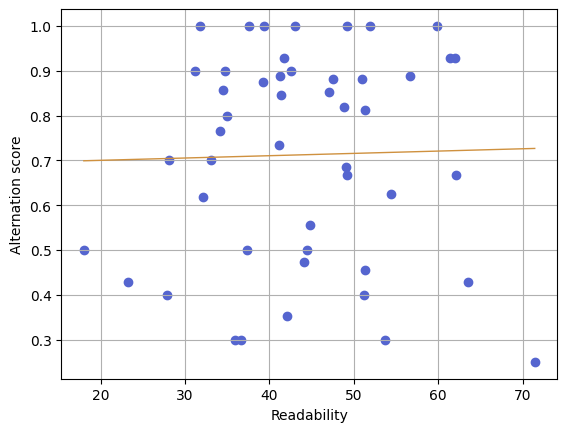

In [ ]:
x = np.array(df_filtered['flesch_reading_ease'])
y = np.array(df_filtered['alternation_score'])
 
# Compute best-fit line (linear regression)
m, b = np.polyfit(x, y, 1)  # 1st-degree polynomial (y = mx + b)
 
# Create scatter plot
plt.scatter(x, y, color=color_palette[0], label="Data points")
 
# Plot best-fit line
x_sorted = np.sort(x)
plt.plot(x_sorted, m*x_sorted + b, color=color_palette[3], linewidth=1, label="Best-fit line")
 
# Labels and title
plt.xlabel("Readability")
plt.ylabel("Alternation score")
plt.grid(True)
# Save as JPG with 300 dpi and EPS (vector format, resolution-independent)
# plt.savefig("outputs/img/19.jpg", dpi=300, bbox_inches="tight", format="jpg")
# plt.savefig("outputs/img/19.eps", format="eps", bbox_inches="tight")
plt.show()

In [ ]:
# Pearson correlation (measures linear relationship)
pearson_corr, pearson_p = pearsonr(x, y)

# Spearman correlation (measures monotonic relationship, rank-based)
spearman_corr, spearman_p = spearmanr(x, y)

print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

# forse non adeguate perché in questo caso la relazione è non lineare e non è monotonica?

Pearson correlation: 0.025 (p-value: 0.867)
Spearman correlation: 0.040 (p-value: 0.787)


C:\Users\giuli\AppData\Local\Temp\ipykernel_21392\1779527898.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['readability_bin'] = pd.cut(df_filtered['flesch_reading_ease'], bins=bins, labels=labels)


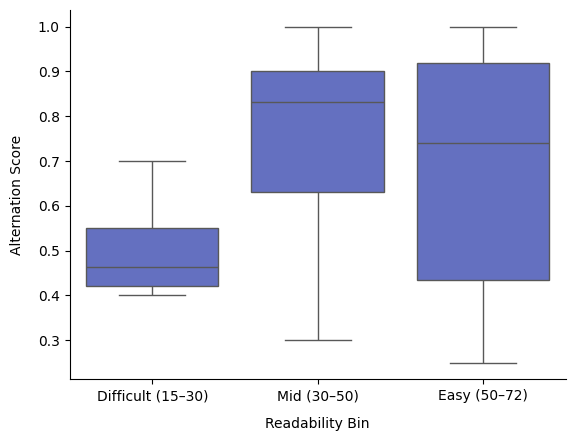

In [16]:
# We suspect that a midle range of readability is best, so we define a Middle Band
bins = [15, 30, 50, 72]
labels = ['Difficult (15–30)', 'Mid (30–50)', 'Easy (50–72)']
df_filtered['readability_bin'] = pd.cut(df_filtered['flesch_reading_ease'], bins=bins, labels=labels)

sns.boxplot(x='readability_bin', y='alternation_score', data=df_filtered, color=color_palette[0])
plt.xlabel('Readability Bin', labelpad=10)
plt.ylabel('Alternation Score', labelpad=10)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Save as JPG with 300 dpi and EPS (vector format, resolution-independent)
plt.savefig("outputs/img/20.jpg", dpi=300, bbox_inches="tight", format="jpg")
plt.savefig("outputs/img/20.eps", format="eps", bbox_inches="tight")

plt.show()



C:\Users\giuli\AppData\Local\Temp\ipykernel_21392\2090825466.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['readability_bin'] = pd.cut(df_filtered['flesch_reading_ease'], bins=bins, labels=labels)


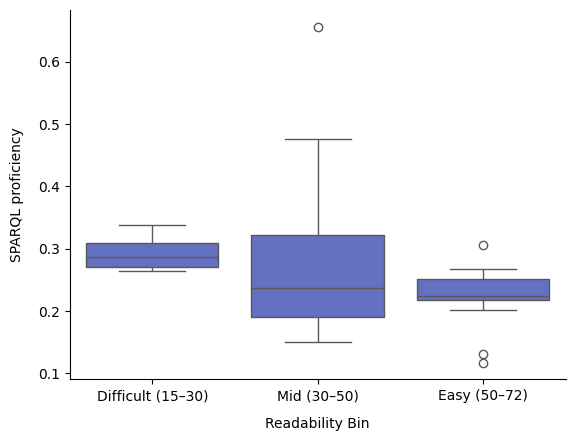

In [10]:
bins = [15, 30, 50, 72] 
labels = ['Difficult (15–30)', 'Mid (30–50)', 'Easy (50–72)']
df_filtered['readability_bin'] = pd.cut(df_filtered['flesch_reading_ease'], bins=bins, labels=labels)

y = np.array(df_filtered['sparql_proficiency'])

sns.boxplot(x='readability_bin', y='sparql_proficiency', data=df_filtered, color=color_palette[0])
plt.xlabel('Readability Bin', labelpad=10)
plt.ylabel('SPARQL proficiency', labelpad=10)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Save as JPG with 300 dpi
# plt.savefig("outputs/img/13.jpg", dpi=300, bbox_inches="tight", format="jpg")

# Save as EPS (vector format, resolution-independent)
# plt.savefig("outputs/img/13.eps", format="eps", bbox_inches="tight")
plt.show()

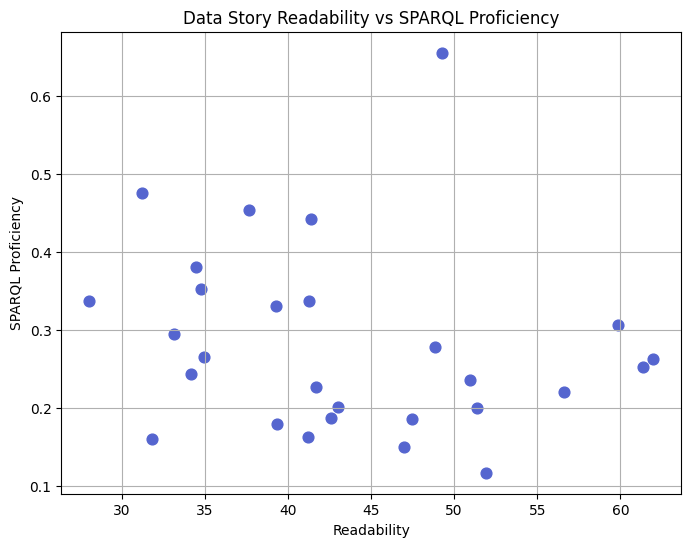

In [12]:
# Create a boolean mask: True if alternation_score > 0.7, else False
high_alternation = df_filtered['alternation_score'] >= 0.7

plt.figure(figsize=(8, 6))

# Plot points with high alternation score
plt.scatter(
    df_filtered.loc[high_alternation, 'flesch_reading_ease'],  # x-values
    df_filtered.loc[high_alternation, 'sparql_proficiency'],      # y-values
    label='High alternation (>=0.7)', 
    marker='o',  # shape of points
    s=60,  # size of points
    color=color_palette[0]
)

plt.xlabel('Readability')
plt.ylabel('SPARQL Proficiency')
plt.title('Data Story Readability vs SPARQL Proficiency')
plt.grid(True)
plt.show()


In [ ]:
df_high = df_filtered[high_alternation]

# Extract the columns of interest
x = df_high['flesch_reading_ease']
y = df_high['sparql_proficiency']

# Pearson correlation (measures linear relationship)
pearson_corr, pearson_p = pearsonr(x, y)

# Spearman correlation (measures monotonic relationship, rank-based)
spearman_corr, spearman_p = spearmanr(x, y)

print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")


Pearson correlation: -0.201 (p-value: 0.306)
Spearman correlation: -0.301 (p-value: 0.120)


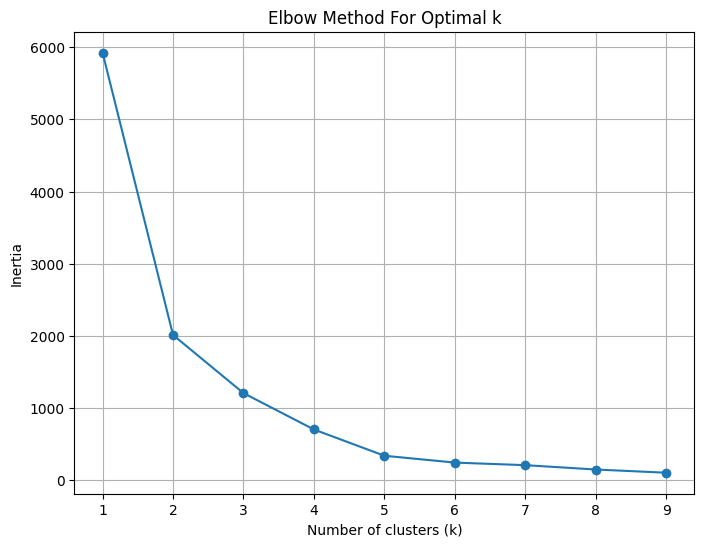

In [13]:
# Import KMeans for clustering
from sklearn.cluster import KMeans

X = df_filtered[['flesch_reading_ease', 'sparql_proficiency']].values

# List to store inertia values for each k
inertia = []

# Range of number of clusters to try (very common default, also small dataset)
k_range = range(1, 10)

# Loop over different values of k to find the inertia
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)  # Sum of squared distances to the closest centroid

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


C:\Users\giuli\AppData\Local\Temp\ipykernel_21392\1211109799.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cluster'] = kmeans.fit_predict(X)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


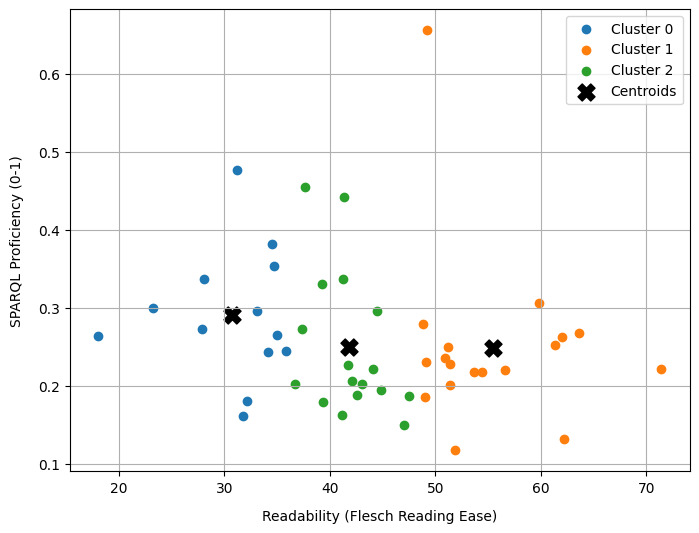

In [14]:
from sklearn.cluster import KMeans

X = df_filtered[['flesch_reading_ease', 'sparql_proficiency']].values

# Set the optimal number of clusters (based on the elbow method)
k_optimal = 3 

kmeans = KMeans(n_clusters=k_optimal, random_state=42)
df_filtered['cluster'] = kmeans.fit_predict(X)

plt.figure(figsize=(8, 6))

for cluster_id in range(k_optimal):
    cluster_points = df_filtered[df_filtered['cluster'] == cluster_id]
    plt.scatter(cluster_points['flesch_reading_ease'], 
                cluster_points['sparql_proficiency'], 
                label=f'Cluster {cluster_id}')

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], 
            s=150, marker='X', c='black', label='Centroids')

plt.xlabel("Readability (Flesch Reading Ease)", labelpad=10)
plt.ylabel("SPARQL Proficiency (0-1)", labelpad=10)
# plt.title(f"KMeans Clustering of Data Stories (k = {k_optimal})", pad=10)
plt.legend()
plt.grid(True)
# Save as JPG with 300 dpi
# plt.savefig("outputs/img/14.jpg", dpi=300, bbox_inches="tight", format="jpg")

# Save as EPS (vector format, resolution-independent)
# plt.savefig("outputs/img/14.eps", format="eps", bbox_inches="tight")

plt.show()
